# Spin-1/2 Non-Abelian Geometric Phase via Floquet Engineering

In [4]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

$$ \hat{\mathcal{H}} = \tilde{\Omega}\left( \sin\phi \hat{F}_x + \cos\phi \hat{F}_y \right) + \tilde{\delta} \hat{F}_z $$
Recall the minus plus sign in front of $\tilde{\delta}$ here, should probably be a minus.

$$ \tilde{\Omega} = \Omega_0 \sin\Omega t \cos\omega t $$
$$ \tilde{\delta} = \Omega_0 \cos\Omega t \cos\omega t $$

$$ \hat{\mathcal{H}}\left( t \right) = \Omega_0 \vec{r} \cdot \hat{\vec{\sigma}} \cos\omega t$$

$$ \vec{r} = \left( \sin\Omega t \cos \Phi, \sin\Omega t \sin \Phi, \cos\Omega t \right)^T $$

In [5]:
#----- Global Settings -----
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()

#--- Projection Operators ---
psi1, psi2 = qt.basis(2,0), qt.basis(2,1) #Two-level basis states
p1, p2 = psi1.proj(), psi2.proj() #Project onto bare spins (z-basis)
eigx, eigy = sx.eigenstates(), sy.eigenstates() #eigenstates of sx, sy
px1, px2 = eigx[1][0].proj(), eigx[1][1].proj() #Corresponding proj. ops.
py1, py2 = eigy[1][0].proj(), eigy[1][1].proj() #Corresponding proj. ops.

proj_ops = [ p1, p2, px1, px2, py1, py2 ] #List of all proj. ops.

## Extended Time-Evolution

In [6]:
#----- Input Parameters -----
Omega0 = 1 #Rabi frequency
Phi = 0 #Operator phase
n_cyc = 10 #Number of Rabi oscillations per op.

#--- Computed Values ---
delta = Omega0 #Field detuning
slow_f = (1/n_cyc)*Omega0 #Slow freq.
floq_f = 2*Omega0 #Floquet freq.

#--- Setup Evolution ---
periods = 4 #Number of periods of slow_f to simulate over
t = np.linspace(0, periods*(2*np.pi/slow_f), num=5000) #Time axis

#--- Initial States ---
psi = psi1 #Initial state
psi = psi.unit() #Force normalization

In [7]:
#----- Time-Dependent Operators -----
H0 = Omega0 * (np.sin(Phi)*sx + np.cos(Phi)*sy) #Coupling term coefficient
H1 = -1*delta*sz #Detuning term coefficient

def coeff0_t(t, args):
    ''' Time-dependent coefficient of H1 '''
    w = args['floq_f'] #Floquet freq.
    Om = args['slow_f'] #Adiabatic freq.
    return np.cos(w*t)*np.sin(Om*t)

def coeff1_t(t, args):
    ''' Time-dependent coefficient of H1 '''
    w = args['floq_f'] #Floquet freq.
    Om = args['slow_f'] #Adiabatic freq.
    return np.cos(w*t)*np.cos(Om*t)

#--- Solve SE ---
H = [ [H0, coeff0_t], [H1, coeff1_t] ] #Full Hamiltonian for func.-based approach
args = {'floq_f':floq_f, 'slow_f':slow_f} #Input params

Psi = qt.sesolve(H, psi, t, e_ops=[p1, p2, px1, px2, py1, py2], args=args)

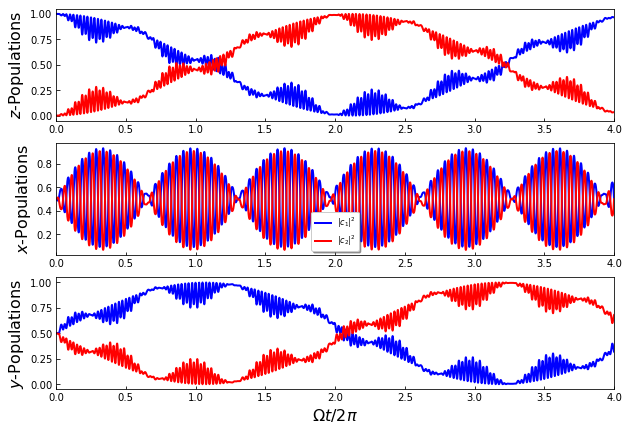

In [8]:
#----- Plot Results -----
fig = plt.figure( figsize=(10,7) )
axz, axx, axy = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
fs = 16 #Label fontsize
labels = ['$|c_{1}|^2$', '$|c_{2}|^2$'] #Plot labels

#--- Draw Plots ---
#Bare spins
axz.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[0], 'b-', lw=2, label=labels[0]) 
axz.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[1], 'r-', lw=2, label=labels[1])

#x-spins
axx.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[2], 'b-', lw=2, label=labels[0]) 
axx.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[3], 'r-', lw=2, label=labels[1])

#y-spins
axy.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[4], 'b-', lw=2, label=labels[0]) 
axy.plot( Psi.times*(slow_f/2/np.pi), Psi.expect[5], 'r-', lw=2, label=labels[1])

#--- Plot Settings ---
axz.set_ylabel('$z$-Populations', fontsize=fs)
axx.set_ylabel('$x$-Populations', fontsize=fs)
axy.set_ylabel('$y$-Populations', fontsize=fs)

axy.set_xlabel('$\Omega t/2\pi$', fontsize=fs) #Comman x-label
axx.legend(loc='best', fancybox=True, shadow=True, framealpha=1, fontsize=8)
for ax in axz, axx, axy:
    ax.set_xlim([0,periods]) #Remove extra spaces at ends
    ax.tick_params(direction='in') #Set grid-ticks inward
plt.show()

## Loops: Evolution Operators

In [9]:
def hamiltonian(t, args):
    ''' Returns the Hamiltonian for qt.sesolve() '''
    
    Omega0 = args['Omega0'] #Rabi freq.
    delta = args['delta'] #Detuning
    
    #----- Time-Dependent Operators -----
    CX = Omega0*sx #Sigma-x coupling term coefficient
    CY = Omega0*sy #Sigma-y coupling term coefficient
    D = -1*delta*sz #Detuning term coefficient
    
    def CX_t(t, args):
        ''' Time-dependent part of CX '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta[0]*t + Theta[1])*np.sin(Phi[0]*t + Phi[1])
    
    def CY_t(t, args):
        ''' Time-dependent part of CY '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta[0]*t + Theta[1])*np.cos(Phi[0]*t + Phi[1])

    def D_t(t, args):
        ''' Time-dependent coefficient of H1 '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        return np.cos(w*t)*np.cos(Theta[0]*t + Theta[1])

    #--- Solve SE ---
    H = [ [CX, CX_t], [CY, CY_t], [D, D_t] ] #Full Hamiltonian for func.-based approach
    
    return H

def loop(psi0, t, Theta, Phi, args):
    '''  '''
    
    args['Theta'], args['Phi'] = Theta, Phi #Add parameteres to args
    H = hamiltonian(t, args) #compute Hamiltonian
    Psi = qt.sesolve(H, psi0, t, args=args) #Solve TDSE
    
    return Psi

In [10]:
#----- Input Parameters -----
Omega0 = 1 #Rabi frequency
n_cyc = 10 #Number of Rabi oscillations per op.

#Computed Values
delta = Omega0 #Field detuning
slow_f = (1/n_cyc)*Omega0 #Slow freq.
floq_f = 2*Omega0 #Floquet freq.

args = {'Omega0':Omega0, 'delta':delta, 'slow_f':slow_f, 'floq_f':floq_f} #Parameter list

#Setup Evolution
t = np.linspace(0, 2*np.pi/slow_f, num=1000) #Time axis

#Initial States
psi0 = psi1 #Initial state
psi0 = psi0.unit() #Force normalization

#----- Loops -----
Thetas = [ [slow_f,0], [slow_f,0], [0,np.pi/2] ] #Thetas for 3 loops of form sin( {0}*t + {1} )
Phis = [ [0,0], [0,np.pi/2], [slow_f,0] ] #Phis for 3 loops of form sin( {0}*t + {1} )

ans1 = loop(psi0, t, Thetas[0], Phis[0], args)
ans2 = loop(psi0, t, Thetas[1], Phis[1], args)
ans3 = loop(psi0, t, Thetas[2], Phis[2], args)
ans1_s, ans2_s, ans3_s = ans1.states[-1], ans2.states[-1], ans3.states[-1]
print( f'Simulation Result: {ans1_s}, {ans2_s}, {ans3_s}' )

Simulation Result: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[7.39136571e-01+0.03012155j]
 [2.84181005e-06-0.67288173j]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.73913657+3.01215536e-02j]
 [-0.67288173-2.84181011e-06j]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.73913539+6.72883262e-01j]
 [0.03011618-2.56642230e-06j]]


In [11]:
from scipy.special import j0

def u_theory(Theta, Phi, phi_const=True):
    '''  '''
    
    g = (1/2) * ( j0(2*Omega0/floq_f) -1 ) #Phase factor

    if phi_const is True:
        'Use phi=const. form'
        U = ( -1j*g * 2*np.pi*(-1*np.cos(Phi[1])*sx + np.sin(Phi[1])*sy) ).expm()
    elif phi_const is False:
        'Use phi linear in t form, assuming no constant part & phi is harmonic of slow_f'
        n = Phi[0]/slow_f
        U = ( -1j*g * (2*np.pi*n * np.sin(Theta[1])**2)*sz ).expm()
    
    return U

#----- Compare to Theory -----
U1, U2, U3 = u_theory(Thetas[0], Phis[0]), u_theory(Thetas[1], Phis[1]), \
    u_theory(Thetas[2], Phis[2], phi_const=False) #Evolution operators
fl1, fl2, fl3 = U1*psi0, U2*psi0, U3*psi0 #Theory states

print( '--- Comparing Results ---' )
print( ans1_s.overlap(fl1) )
print( ans2_s.overlap(fl2) )
print( ans3_s.overlap(fl3) )

print('')
g = (1/2) * ( j0(2*Omega0/floq_f) -1 ) #Phase factor
print( '--- Wilson Loops ---' )
print( ( U3*(U2*U1 - U1*U2) ).tr() )
print( -4*( np.sin(2*np.pi*g)**3 ) )

--- Comparing Results ---
(0.9995458757825944-0.022293334719184144j)
(0.9995458757825952-0.022293334719199028j)
(0.9995460360488326-0.0008587832264496109j)

--- Wilson Loops ---
1.216857162205843
1.216857162205843
